In [1532]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import pandas as pd
import mne
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score


In [1533]:
def load_files(session_num, behavior_csv, verbose=False):
    """

    ****setup****
    file and folder paths
    load data


    """
    folderpath='data/misc/'
    

    eeg_raw=np.load(folderpath + 'eeg_run-' + str(session_num) + '.npy')/1000000 # divide by 1,000,000 scales units to microvolts for MNE
    photo_raw=np.load(folderpath + 'aux_run-' + str(session_num) + '.npy')[1][1:]
    behavior = pd.read_csv(behavior_csv)
    master_df = behavior[behavior.columns[2:]].iloc[:-1] #get rid of first two columns and last trial (row)



    # remove first data point of eeg across all channels
    eeg=np.zeros((eeg_raw.shape[0], eeg_raw.shape[1]-1))
    for ch in range(eeg_raw.shape[0]):
        eeg[ch]=eeg_raw[ch][1:]



    
    # binarize photo signal --> greater than 1 std above mean = useable eeg data 
    photo_thresh = photo_raw.mean()-photo_raw.std()
    photo_binary=(photo_raw>photo_thresh).astype(float)

    # smooth binarization by requiring 3 consecutive samples of no light on sensor
    for i in range(len(photo_binary)):
        if i<len(photo_binary)-1:
            if np.mean(photo_binary[i:i+3])!=0.0:
                photo_binary[i]=1.0

    # extract timestamps (where sensor changes state)
    timestamps=[]
    for i in range(len(photo_binary)-1):
        if photo_binary[i]!=photo_binary[i+1]:
            timestamps.append(i)

    # drop first on/off timestamps (this is sensor press is to start the session)
    timestamps=timestamps[2:]

    # label timestamps and store in dictionary
    timestamps_dict={'talk_on':timestamps[::2],'talk_off':timestamps[1::2]}
    
    channel_list = ["FP1", "FP2", "T3", "T4", "T5", "P3", "P4", "T6"]
    session_info = mne.create_info(ch_names = channel_list, ch_types = ["eeg"]*8, sfreq = 250)
    raw = mne.io.RawArray(eeg, info=session_info)
    raw.filter(l_freq=7, h_freq=14)


    # check that number of timestamps, photo sensor events, and trials matches
    # save number of trials
    session_len = master_df.shape[0]
    talk_on_num = len(timestamps_dict['talk_on'])
    talk_off_num = len(timestamps_dict['talk_off'])
    session_len_check = session_len==talk_on_num and session_len==talk_off_num
    
    

    

    if verbose==True:

        print('*'*30)
        print('eeg shape: ', eeg.shape)
        print('photo shape: ', photo_raw.shape)
        print('timestamps_dict shape: ', len(timestamps_dict['talk_on']), ' & ', len(timestamps_dict['talk_off']))
        print('\nTIMESTAMPS DICT\n', timestamps_dict)
        print('\nTRIAL NUMBER CONSISTENT ACROSS DATA MODALITIES: ', session_len_check)
        print('*'*30, '\n')

        
        # inspect descriptive stats
        print(raw.describe())
        
        # # render visualization of entire recording for all channels
        raw.plot(n_channels=8, duration=np.inf)

        #inspect photo sensor binarization
        plt.plot(photo_binary)
        plt.show()

        # inspect DataFrame
        print(master_df)

    return raw.get_data(), photo_binary, timestamps_dict, master_df, session_len

In [1534]:
# eeg, aux, timestamps, data_df, n_trials = load_files(3, 'trial_2025-03-08_1741468439.817664.csv', verbose=True)

In [1535]:
def ch_windows(eeg_data, timestamps_dict, trial_num, timestamp_label, window_dur):
    """
    get window before each 'talk_on' or after each 'talk_off' timestampt

    eeg_data: 8 channels of eeg in np.array format, entire session
    trial_num: number of trial to access
    timestamp_label: from timestamp dictionary --> 'talk_on' or 'talk_off'
    window_dur: length of window (in samples)
    """
    epoch = np.zeros((8, window_dur), dtype=np.float64)
    timestamp = timestamps_dict[timestamp_label][trial_num]
    for i, ch in enumerate(eeg_data):
        if timestamp_label == 'talk_on':
            window = ch[timestamp-window_dur:timestamp]
        else:
            window = ch[timestamp:timestamp+window_dur]
        epoch[i] =  window
    return epoch

def get_all_windows(eeg_data, window_dur, timestamps_dict, session_length):

    pre = np.zeros((session_length, 8, window_dur), dtype=np.float64)
    post = np.zeros((session_length, 8, window_dur), dtype=np.float64)

    for stamp_label in timestamps_dict:
        trial=0
        for timestamp in timestamps_dict[stamp_label]:
            if trial>session_length-1:
                break
            windows = ch_windows(eeg_data, timestamps_dict, trial, stamp_label, window_dur)
            if stamp_label=='talk_on':
                pre[trial] = windows
            else:
                post[trial] = windows
            trial+=1
    return list(pre), list(post)



def epochs_to_df(eeg_data, master_df, timestamps_dict, session_length):

    master_df['pre_eeg'],master_df['post_eeg'] = get_all_windows(
        eeg_data, 500, timestamps_dict, session_length)

    return master_df

# data_df = epochs_to_df(eeg, data_df, timestamps, n_trials)
# data_df


In [1536]:
def ch_psd(array):
    freqs, psds = welch(array, fs = 250, scaling = 'spectrum')
    return psds[8:14]#

def trial_psds(arrays):
    return [ch_psd(array) for array in arrays]

def psds_to_df(master_df):
    master_df['pre_psds'] = master_df['pre_eeg'].apply(trial_psds)
    master_df['post_psds'] = master_df['post_eeg'].apply(trial_psds)
    return master_df




In [1537]:
def full_pipeline_df(session_number, csv_filepath):
    #print(':'*40)
    #print(':'*13, 'SESSION No.', session_number, ':'*12)
    #print(':'*40)
    eeg, aux, timestamps, data_df, n_trials = load_files(session_number, csv_filepath, verbose=False);
    data_df = epochs_to_df(eeg, data_df, timestamps, n_trials)
    data_df = psds_to_df(data_df)
    return data_df


In [1538]:
s2=full_pipeline_df(2,'trial_2025-03-03.csv');
s3=full_pipeline_df(3,'trial_2025-03-08_1741468439.817664.csv');
s4=full_pipeline_df(4,'trial_2025-03-08_1741468843.7260554.csv');
s5=full_pipeline_df(5,'trial_2025-03-08_1741469610.0329673.csv');
s6=full_pipeline_df(6,'trial_2025-03-08_1741470378.8003502.csv');
s7=full_pipeline_df(7,'trial_2025-03-08_1741470954.5934713.csv');
s8=full_pipeline_df(8,'trial_2025-03-08_1741472154.896084.csv');
s9=full_pipeline_df(9,'trial_2025-03-08_1741472587.6947665.csv');
s10=full_pipeline_df(10, 'trial_2025-03-08_1741472989.529014.csv');

Creating RawArray with float64 data, n_channels=8, n_times=47737
    Range : 0 ... 47736 =      0.000 ...   190.944 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 413 samples (1.652 s)

Creating RawArray with float64 data, n_channels=8, n_times=53870
    Range : 0 ... 53869 =      0.000 ...   215.476 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass

In [1539]:
full_df = pd.concat([s2, s3, s4, s5, s6, s7, s8, s10.iloc[:6]]).reset_index()#s2, s3, s4, s5, s6, s7, s8, s9, s10.iloc[:6]
partial_df = pd.concat([s3, s4, s5, s6, s7, s8]).reset_index()
no_electrical_signal = pd.concat([s2, s10.iloc[:6]]).reset_index()
ready_df = full_df.sort_values(by=['truth_value']).iloc[3:];

In [1540]:
def convert_label(label):
    return 0 if label =='fact' else 1



def run_LDA(master_df, kind, when='post'):

    # Organize data for model
    if kind == 'max':
        X = np.array([np.max(psd, axis=0) for psd in master_df[f'{when}_psds']])  # Flatten each 8xN array
    elif kind == 'mean':
        X = np.array([np.mean(psd, axis=0) for psd in master_df[f'{when}_psds']])
    elif kind == 'median':
        X = np.array([np.median(psd, axis=0) for psd in master_df[f'{when}_psds']])
    elif kind == 'min':
        X = np.array([np.min(psd, axis=0) for psd in master_df[f'{when}_psds']])
    y = master_df['truth_value'].apply(convert_label)  # Binary labels

    #print(X.shape)
    # Check class distribution in the full dataset
    print("\nFull Dataset Class Distribution:\n", pd.Series(y).value_counts())

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6, stratify=y, shuffle=True)


    # Check class distribution in training and test sets
    #print("\nTraining Set Class Distribution:\n", pd.Series(y_train).value_counts())
    #print("\nTest Set Class Distribution:\n", pd.Series(y_test).value_counts())
    # Initialize and train LDA model
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)

    # Predict on test data

    # Compute accuracy using cross-validation
    accuracy = cross_val_score(lda, X_train, y_train, cv=5).mean()

    # Print results
    print(f"\n******************\nScore:{lda.score(X_test, y_test):.4f}")
    return lda, X_train, X_test, y_train, y_test

In [1541]:
lda, X_train, X_test, y_train, y_test= run_LDA(partial_df, 'median', 'post')


Full Dataset Class Distribution:
 truth_value
1    45
0    43
Name: count, dtype: int64

******************
Score:0.5556


In [1542]:
lda, X_train, X_test, y_train, y_test= run_LDA(no_electrical_signal, 'median', 'post')


Full Dataset Class Distribution:
 truth_value
1    11
0    10
Name: count, dtype: int64

******************
Score:0.2000


In [1543]:
lda, X_train, X_test, y_train, y_test= run_LDA(full_df, 'median', 'post')


Full Dataset Class Distribution:
 truth_value
1    56
0    53
Name: count, dtype: int64

******************
Score:0.7273


In [1544]:
master_df = full_df

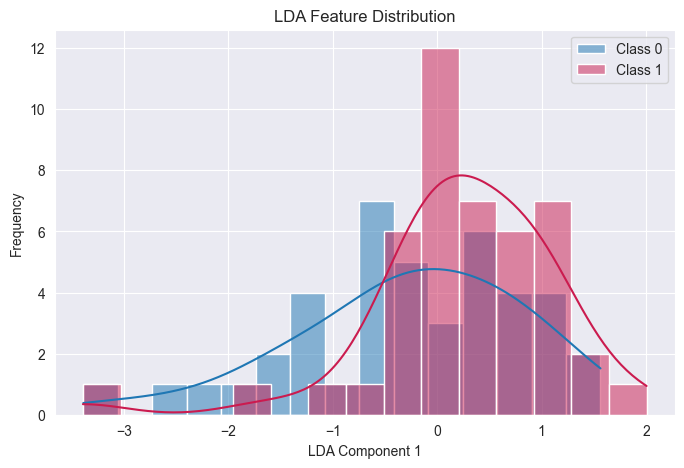

In [1545]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transform features into LDA space
X_lda = lda.transform(X_train)

# Plot LDA-transformed feature distribution
plt.figure(figsize=(8, 5))
sns.histplot(X_lda[y_train == 0], color="blue", label="Class 0", bins=15, kde=True)
sns.histplot(X_lda[y_train == 1],palette='rocket', label="Class 1", bins=15, kde=True)

plt.xlabel("LDA Component 1")
plt.ylabel("Frequency")
plt.title("LDA Feature Distribution")
plt.legend()
plt.show();